In [1]:
import torch
from torch import nn, optim
from torchvision.transforms import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

torch.Size([3, 128, 128])


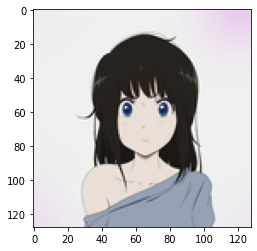

In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

flat_img = 128*128*3
img = Image.open("data/gen.png")
real_img = transform(img)

torch.manual_seed(2)
fake_img = torch.rand(1, 100)

plt.imshow(np.transpose(real_img.numpy(), (1, 2, 0)))
print(real_img.size())

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(flat_img, 10000),
            nn.ReLU(),
            nn.Linear(10000, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img = img.view(1, -1)
        out = self.linear(img)

        return out


In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(100, 10000),
            nn.LeakyReLU(),
            nn.Linear(10000, 4000),
            nn.LeakyReLU(),
            nn.Linear(4000, flat_img)
        )

    def forward(self, latent_space):
        latent_space = latent_space.view(1, -1)
        out = self.linear(latent_space)

        return out


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

discr = Discriminator().to(device)
gen = Generator().to(device)

opt_d = optim.SGD(discr.parameters(), lr=0.01, momentum=0.9)
opt_g = optim.SGD(gen.parameters(), lr=0.01, momentum=0.9)

criterion = nn.BCELoss()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 15; G_loss: -0.003727; D1_loss: 0.000000; D2_loss: 0.002633


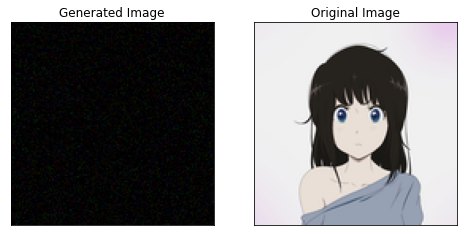

[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [6]:
from IPython.display import clear_output
from torchvision.utils import save_image

epochs = 500
discr_e = 4
gen_e = 3

def display_img(gen_output):
    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.title("Generated Image")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.transpose(out_g.resize(3, 128, 128).cpu().detach().numpy(), (1, 2, 0)))

    plt.subplot(1, 2, 2)
    plt.title("Original Image")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.transpose(real_img.numpy(), (1, 2, 0)))
    plt.show()

for epoch in range(epochs):
    for k in range(discr_e):
        opt_d.zero_grad()

        out_d1 = discr(real_img.to(device))

        loss_d1 = criterion(out_d1, torch.ones(1, 1).to(device))
        loss_d1.backward()

        out_d2 = gen(fake_img.to(device)).detach()
        
        loss_d2 = criterion(discr(out_d2.to(device)), torch.zeros((1, 1)).to(device))
        loss_d2.backward()

        opt_d.step()
    
    for i in range(gen_e):
        opt_g.zero_grad()

        out_g = gen(fake_img.to(device))

        loss_g = torch.log(1.0 - (discr(out_g.to(device))))
        loss_g.backward()

        opt_g.step()

    clear_output(wait=True)
    print('epoch: {}; G_loss: {:.6f}; D1_loss: {:.6f}; D2_loss: {:.6f}'.format(epoch+1, loss_g.item(), loss_d1.item(), loss_d2.item()))
    display_img(gen_output=out_g)
    save_image(out_g.resize(3, 128, 128), f"output/output_{epoch+1}.png")